# Homography Estimation — On-the-fly Training (PyTorch)

This notebook trains a CNN to estimate homography between two 64×64 patches built from:
- **2-channel input** (original patch, warped patch)
- **Backbone:** 4 stages, each with **2 ResNet blocks**; channels 64→64→128→128, BN+ReLU, MaxPool between stages.
- **Heads:** 
  - Regression (8 real-valued corner offsets; L2/RMSE)
  - Classification (8×K bins; cross-entropy)
  
It is designed to work **on the fly** with your image-preparation utilities.

## 0) Environment
Install dependencies (CPU only is fine).

In [35]:
# If needed, uncomment to install in a fresh environment
# %pip install torch torchvision opencv-python numpy matplotlib

## 1) Imports & Config
Set your image directory and general training hyperparameters.

In [13]:
import os, math, time, json
from pathlib import Path
from dataclasses import dataclass
import cv2 as cv

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from typing import Tuple, List, Optional, Dict
import glob


import matplotlib.pyplot as plt

IMG_DIR = "coco_images"
TARGET_SIZE = (320, 240)
PATCH = 64
MAX_JITTER = 16
BINS = 21
DTYPE = np.float32
LR      = 3e-4
STEPS   = 50000
BATCH   = 4
EPOCH_SAMPLES = 5000
SEED    = 123
CKPT_DIR = "checkpoints"
CKPT_PATH_REG = os.path.join(CKPT_DIR, "homography_reg.pt")
CKPT_PATH_CLS = os.path.join(CKPT_DIR, "homography_cls.pt")

torch.manual_seed(SEED)
np.random.seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cpu


## 2) Paste your image-preparation code (or import it)

> **Option A:** Paste your existing functions/classes below (\_to_gray_uchar, \_load_and_preprocess, generate_sample_from_image, HomographyDatasetOnTheFly, ...).  
> **Option B:** Import them from your module, e.g. `from your_module import HomographyDatasetOnTheFly`

In [32]:
def _to_gray_uchar(img_bgr: np.ndarray) -> np.ndarray:
    if img_bgr.ndim == 3 and img_bgr.shape[2] == 3:
        g = cv.cvtColor(img_bgr, cv.COLOR_BGR2GRAY)
    elif img_bgr.ndim == 2:
        g = img_bgr
    else:
        raise ValueError("Unsupported image format")
    return g

def _load_and_preprocess(path: str, target_size: Tuple[int, int]) -> np.ndarray:
    img = cv.imread(path, cv.IMREAD_COLOR)
    if img is None:
        raise IOError(f"Failed to read image: {path}")
    img = cv.resize(img, target_size, interpolation=cv.INTER_AREA)
    g = _to_gray_uchar(img)
    return g

# def _random_window(rng: np.random.Generator, W: int, H: int, patch: int, margin: int) -> Tuple[int, int]:
#     x = rng.integers(margin, W - patch - margin + 1)
#     y = rng.integers(margin, H - patch - margin + 1)
#     return int(x), int(y)
def _random_window(rng: np.random.Generator, W: int, H: int, patch: int, margin: int) -> Tuple[int, int]:
    # Fixed position for a 64x64 patch on a 256x256 image (centered)
    x = (W - patch) // 2
    y = (H - patch) // 2
    return int(x), int(y)

def _perturb_corners(rng: np.random.Generator, x: int, y: int, patch: int, max_jitter: int) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    tl = np.array([x,         y        ], dtype=np.float32)
    tr = np.array([x + patch, y        ], dtype=np.float32)
    br = np.array([x + patch, y + patch], dtype=np.float32)
    bl = np.array([x,         y + patch], dtype=np.float32)
    pts_src = np.stack([tl, tr, br, bl], axis=0)

    jit = rng.integers(-max_jitter, max_jitter + 1, size=(4, 2)).astype(np.float32)
    pts_dst = pts_src + jit
    offsets = (pts_dst - pts_src).reshape(-1)
    return pts_src, pts_dst, offsets


# def _perturb_corners(rng: np.random.Generator, x: int, y: int, patch: int, max_jitter: int) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
#     tl = np.array([x,         y        ], dtype=np.float32)
#     tr = np.array([x + patch, y        ], dtype=np.float32)
#     br = np.array([x + patch, y + patch], dtype=np.float32)
#     bl = np.array([x,         y + patch], dtype=np.float32)
#     pts_src = np.stack([tl, tr, br, bl], axis=0)

#     # Fixed jitter values (for deterministic testing)
#     jit = np.array([
#         [-11,  3],
#         [ 14,  3],
#         [ 6, -8],
#         [3, 4]
#     ], dtype=np.float32)

#     pts_dst = pts_src + jit
#     offsets = (pts_dst - pts_src).reshape(-1)
#     return pts_src, pts_dst, offsets

def _safe_margin_for_jitter(max_jitter: int) -> int:
    # We keep enough margin so that the quadrilateral remains within image after perturbation.
    # A conservative choice is max_jitter to each side.
    return max_jitter


def _crop(gray: np.ndarray, x: int, y: int, patch: int) -> np.ndarray:
    return gray[y:y+patch, x:x+patch]

def _stack_two_channel(a: np.ndarray, b: np.ndarray) -> np.ndarray:
    a = (a.astype(DTYPE) / 255.0)
    b = (b.astype(DTYPE) / 255.0)
    return np.stack([a, b], axis=0)

def _bin_centers(bins: int, max_jitter: int) -> np.ndarray:
    return np.linspace(-max_jitter, max_jitter, bins, dtype=DTYPE)

def quantize_offsets(offsets_8: np.ndarray, bins: int = BINS, max_jitter: int = MAX_JITTER) -> np.ndarray:
    centers = _bin_centers(bins, max_jitter)
    idxs = []
    for v in offsets_8.astype(DTYPE):
        i = int(np.argmin(np.abs(centers - v)))
        idxs.append(i)
    return np.array(idxs, dtype=np.int64)

def one_hot_8xB(class_idxs_8: np.ndarray, bins: int = BINS) -> np.ndarray:
    y = np.zeros((8, bins), dtype=DTYPE)
    for i, c in enumerate(class_idxs_8):
        y[i, c] = 1.0
    return y
def generate_sample_from_image(gray_240x320: np.ndarray,
                               rng: Optional[np.random.Generator] = None,
                               patch: int = PATCH,
                               max_jitter: int = MAX_JITTER,
                               return_cls: bool = True) -> Dict[str, np.ndarray]:
    if rng is None:
        rng = np.random.default_rng()

    H_img, W_img = gray_240x320.shape[:2]
    margin = _safe_margin_for_jitter(max_jitter)
    x, y = _random_window(rng, W_img, H_img, patch, margin)

    pts_src, pts_dst, offsets = _perturb_corners(rng, x, y, patch, max_jitter)
    H = cv.getPerspectiveTransform(pts_src.astype(np.float32), pts_dst.astype(np.float32))
    H_inv = np.linalg.inv(H)
    warped = cv.warpPerspective(gray_240x320, H_inv, (W_img, H_img), flags=cv.INTER_LINEAR, borderMode=cv.BORDER_REPLICATE)

    crop_a = _crop(gray_240x320, x, y, patch)
    crop_b = _crop(warped,       x, y, patch)
    x2 = _stack_two_channel(crop_a, crop_b)

    out = {
        "x": x2,
        "y_reg": offsets.astype(DTYPE),
        "H": H.astype(DTYPE),
        "xy": np.array([x, y], dtype=np.int32),
    }
    if return_cls:
        idxs = quantize_offsets(offsets, bins=BINS, max_jitter=max_jitter)
        out["y_cls_idx"] = idxs
        out["y_cls_oh"] = one_hot_8xB(idxs, bins=BINS)
    return out

def image_paths_from_dir(img_dir: str, exts: Tuple[str, ...] = (".jpg", ".jpeg", ".png")) -> List[str]:
    ps = []
    for e in exts:
        ps.extend(glob.glob(os.path.join(img_dir, f"*{e}")))
    return sorted(ps)

class HomographyDatasetOnTheFly:
    def __init__(self,
                 img_dir: str = IMG_DIR,
                 seed: Optional[int] = None,
                 patch: int = PATCH,
                 max_jitter: int = MAX_JITTER,
                 return_cls: bool = True):
        self.paths = image_paths_from_dir(img_dir)
        if not self.paths:
            raise RuntimeError(f"No images found in {img_dir}")
        self.rng = np.random.default_rng(seed)
        self.patch = patch
        self.max_jitter = max_jitter
        self.return_cls = return_cls

    def __len__(self):
        return len(self.paths)

    def _rand_img(self) -> np.ndarray:
        p = self.paths[self.rng.integers(0, len(self.paths))]
        g = _load_and_preprocess(p, TARGET_SIZE)
        return g

    def sample(self) -> Dict[str, np.ndarray]:
        g = self._rand_img()
        return generate_sample_from_image(
            g, rng=self.rng, patch=self.patch, max_jitter=self.max_jitter, return_cls=self.return_cls
        )

def load_model(head_type, ckpt_path, bins=BINS, device=device):
    model = HomographyNet(head_type=head_type, bins=bins).to(device)
    state = torch.load(ckpt_path, map_location=device)
    model.load_state_dict(state["model"])
    model.eval()
    print(f"Loaded {head_type} model from: {ckpt_path}")
    return model

def sample_with_full(ds, return_cls=True):
    gray = ds._rand_img()

    H_img, W_img = gray.shape[:2]
    patch = ds.patch
    max_jitter = ds.max_jitter

    margin = max_jitter
    rng = ds.rng
    x, y = _random_window(rng, W_img, H_img, patch, margin)
    pts_src, pts_dst, offsets = _perturb_corners(rng, x, y, patch, max_jitter)

    H = cv.getPerspectiveTransform(pts_src.astype(np.float32), pts_dst.astype(np.float32))
    H_inv = np.linalg.inv(H)
    warped = cv.warpPerspective(gray, H_inv, (W_img, H_img), flags=cv.INTER_LINEAR, borderMode=cv.BORDER_REPLICATE)

    crop_a = _crop(gray,   x, y, patch)
    crop_b = _crop(warped, x, y, patch)
    x2 = _stack_two_channel(crop_a, crop_b)

    out = {
        "x": x2,
        "y_reg": offsets.astype(DTYPE),
        "H": H.astype(DTYPE),
        "xy": np.array([x, y], dtype=np.int32),
        "gray_full": gray,
        "warped_full": warped
    }
    if return_cls:
        idxs = quantize_offsets(offsets, bins=BINS, max_jitter=max_jitter)
        out["y_cls_idx"] = idxs
        out["y_cls_oh"]  = one_hot_8xB(idxs, bins=BINS)
    return out

def quad_from_xy_offsets(xy_tl, patch, offsets8):
    x, y = map(int, xy_tl)
    src = np.array([[x, y],[x+patch, y],[x+patch, y+patch],[x, y+patch]], dtype=np.float32)
    dst = src + offsets8.reshape(4,2).astype(np.float32)
    return src, dst

def H_from_offsets(xy_tl, patch, offsets8):
    src, dst = quad_from_xy_offsets(xy_tl, patch, offsets8)
    H  = cv.getPerspectiveTransform(src, dst)
    Hinv = np.linalg.inv(H)
    return H, Hinv, src, dst

def draw_full_overlay(gray_full, src_quad, dst_gt, dst_pred, title="Full image (RED=pred, GREEN=GT, WHITE=orig)"):
    img = cv.cvtColor(gray_full, cv.COLOR_GRAY2BGR)
    cv.polylines(img, [src_quad.astype(np.int32)], True, (255,255,255), 1, cv.LINE_AA)
    cv.polylines(img, [dst_gt.astype(np.int32)],  True, (0,200,0),     2, cv.LINE_AA)
    cv.polylines(img, [dst_pred.astype(np.int32)],True, (0,0,255),     2, cv.LINE_AA)

    for i in range(4):
        p1 = tuple(dst_gt[i].astype(int)); p2 = tuple(dst_pred[i].astype(int))
        cv.line(img, p1, p2, (0,200,200), 1, cv.LINE_AA)
    plt.figure(figsize=(6,4)); plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB)); plt.title(title); plt.axis("off"); plt.show()

def checkerboard_blend(a, b, tiles=8):
    h,w = a.shape
    tile_h, tile_w = h//tiles, w//tiles
    out = np.zeros_like(a)
    for i in range(tiles):
        for j in range(tiles):
            ys,ye = i*tile_h, (i+1)*tile_h if i<tiles-1 else h
            xs,xe = j*tile_w, (j+1)*tile_w if j<tiles-1 else w
            if (i+j)%2==0: out[ys:ye, xs:xe] = a[ys:ye, xs:xe]
            else:          out[ys:ye, xs:xe] = b[ys:ye, xs:xe]
    return out

def patch_viz(x2, pred_offsets, gt_offsets, patch=64, title="Patch view"):
    a = (x2[0]*255).astype(np.uint8)
    b = (x2[1]*255).astype(np.uint8)

    src_local = np.array([[0,0],[patch,0],[patch,patch],[0,patch]], np.float32)
    dst_pred_local = src_local + pred_offsets.reshape(4,2).astype(np.float32)
    H_pred = cv.getPerspectiveTransform(src_local, dst_pred_local)
    Hinv_pred = np.linalg.inv(H_pred)
    a_aligned = cv.warpPerspective(a, Hinv_pred, (patch,patch), flags=cv.INTER_LINEAR, borderMode=cv.BORDER_REPLICATE)

    cb = checkerboard_blend(a_aligned, b, tiles=8)
    diff = cv.absdiff(a_aligned, b)

    dst_gt_local = src_local + gt_offsets.reshape(4,2).astype(np.float32)
    err = np.linalg.norm(dst_pred_local - dst_gt_local, axis=1)
    rmse = float(np.sqrt(np.mean((dst_pred_local - dst_gt_local)**2)))

    fig, axs = plt.subplots(1,4, figsize=(12,3))
    axs[0].imshow(a, cmap="gray"); axs[0].set_title("orig (ch0)"); axs[0].axis("off")
    axs[1].imshow(b, cmap="gray"); axs[1].set_title("target (ch1)"); axs[1].axis("off")
    axs[2].imshow(a_aligned, cmap="gray"); axs[2].set_title("orig aligned (pred)"); axs[2].axis("off")
    axs[3].imshow(diff, cmap="gray"); axs[3].set_title("abs diff"); axs[3].axis("off")
    fig.suptitle(f"{title}  |  corner err px: {np.round(err,2)}  |  RMSE: {rmse:.2f}")
    plt.show()

    plt.figure(figsize=(3.2,3.2)); plt.imshow(cb, cmap="gray"); plt.title("checkerboard: pred-align vs target"); plt.axis("off"); plt.show()


def draw_homography_overlay(gray_full, x, y, patch, offsets_pred, offsets_gt=None, title=""):
    Himg, Wimg = gray_full.shape[:2]
    img = cv.cvtColor(gray_full, cv.COLOR_GRAY2BGR)

    src = np.array([[x, y],
                    [x+patch, y],
                    [x+patch, y+patch],
                    [x, y+patch]], dtype=np.float32)

    dst_pred = src + offsets_pred.reshape(4,2).astype(np.float32)

    cv.polylines(img, [src.astype(np.int32)], isClosed=True, color=(255,255,255), thickness=1, lineType=cv.LINE_AA)

    cv.polylines(img, [dst_pred.astype(np.int32)], isClosed=True, color=(0,0,255), thickness=2, lineType=cv.LINE_AA)

    if offsets_gt is not None:
        dst_gt = src + offsets_gt.reshape(4,2).astype(np.float32)
        cv.polylines(img, [dst_gt.astype(np.int32)], isClosed=True, color=(0,200,0), thickness=2, lineType=cv.LINE_AA)

        for i in range(4):
            p1 = tuple(dst_gt[i].astype(int))
            p2 = tuple(dst_pred[i].astype(int))
            cv.line(img, p1, p2, (0,200,200), 1, lineType=cv.LINE_AA)

    plt.figure(figsize=(6,4))
    plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
    plt.title(title or "Homography overlay (RED=pred, GREEN=GT, white=patch)")
    plt.axis("off")
    plt.show()

def warp_full_with_pred(gray_full, x, y, patch, offsets_pred):
    src = np.array([[x, y],
                    [x+patch, y],
                    [x+patch, y+patch],
                    [x, y+patch]], dtype=np.float32)
    dst = src + offsets_pred.reshape(4,2).astype(np.float32)

    H = cv.getPerspectiveTransform(src, dst)
    H_inv = np.linalg.inv(H)

    h, w = gray_full.shape[:2]
    aligned = cv.warpPerspective(gray_full, H_inv, (w, h), flags=cv.INTER_LINEAR, borderMode=cv.BORDER_REPLICATE)
    return aligned

## 3) Torch Dataset wrapper (on-the-fly)
Wraps your `HomographyDatasetOnTheFly` so each `__getitem__` draws a fresh sample.

In [36]:
class TorchHomographyDataset(Dataset):
    def __init__(self, base_ds, n_samples_per_epoch=5000, for_classification=True):
        self.ds = base_ds
        self.n = int(n_samples_per_epoch)
        self.for_classification = for_classification

    def __len__(self):
        return self.n

    def __getitem__(self, idx):
        s = self.ds.sample()
        x = torch.from_numpy(s["x"]).float()        # (2,64,64)
        y_reg = torch.from_numpy(s["y_reg"]).float()# (8,)

        if self.for_classification:
            y_idx = torch.from_numpy(s["y_cls_idx"]).long()  # (8,)
            return {"x": x, "y_reg": y_reg, "y_cls_idx": y_idx}
        else:
            return {"x": x, "y_reg": y_reg}

## 4) Model — Backbone and Heads

Architecture per the spec:
- 4 stages, each with **2 residual blocks**  
- Channels: 64 → 64 → 128 → 128  
- BN + ReLU, MaxPool between stages (except last, which omits pooling)  
- Final **FC(512)**, then head

In [21]:
# class BasicResBlock(nn.Module):
#     def __init__(self, ch: int):
#         super().__init__()
#         self.conv1 = nn.Conv2d(ch, ch, kernel_size=3, padding=1, bias=False)
#         self.bn1   = nn.BatchNorm2d(ch)
#         self.conv2 = nn.Conv2d(ch, ch, kernel_size=3, padding=1, bias=False)
#         self.bn2   = nn.BatchNorm2d(ch)

#     def forward(self, x):
#         identity = x
#         out = self.conv1(x)
#         out = self.bn1(out)
#         out = F.relu(out, inplace=True)
#         out = self.conv2(out)
#         out = self.bn2(out)
#         out = out + identity
#         out = F.relu(out, inplace=True)
#         return out

# class HomographyBackbone(nn.Module):
#     def __init__(self, in_ch=2):
#         super().__init__()
#         self.stem = nn.Conv2d(in_ch, 64, kernel_size=3, padding=1, bias=False)

#         # Stage 1 (64)
#         self.b1a = BasicResBlock(64)
#         self.b1b = BasicResBlock(64)
#         self.bn1 = nn.BatchNorm2d(64)
#         self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # 64->32

#         # Stage 2 (64)
#         self.b2a = BasicResBlock(64)
#         self.b2b = BasicResBlock(64)
#         self.bn2 = nn.BatchNorm2d(64)
#         self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)  # 32->16

#         # Stage 3 (128)
#         self.up3 = nn.Conv2d(64, 128, kernel_size=1, bias=False)
#         self.b3a = BasicResBlock(128)
#         self.b3b = BasicResBlock(128)
#         self.bn3 = nn.BatchNorm2d(128)
#         self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)  # 16->8

#         # Stage 4 (128)
#         self.b4a = BasicResBlock(128)
#         self.b4b = BasicResBlock(128)
#         self.bn4 = nn.BatchNorm2d(128)

#         self.flatten = nn.Flatten()
#         self.fc = nn.Linear(128 * 8 * 8, 512)  # 64x64 -> 8x8 after 3 pools

#     def forward(self, x):
#         x = self.stem(x)               # (B,64,64,64)
#         x = self.b1a(x); x = self.b1b(x)
#         x = self.bn1(x); x = F.relu(x, inplace=True); x = self.pool1(x)  # -> 32x32

#         x = self.b2a(x); x = self.b2b(x)
#         x = self.bn2(x); x = F.relu(x, inplace=True); x = self.pool2(x)  # -> 16x16

#         x = self.up3(x)
#         x = self.b3a(x); x = self.b3b(x)
#         x = self.bn3(x); x = F.relu(x, inplace=True); x = self.pool3(x)  # -> 8x8

#         x = self.b4a(x); x = self.b4b(x)
#         x = self.bn4(x); x = F.relu(x, inplace=True)

#         x = self.flatten(x)
#         x = self.fc(x)
#         x = F.relu(x, inplace=True)
#         return x

# class RegressionHead(nn.Module):
#     def __init__(self, in_ch=512, max_jitter=16.0):
#         super().__init__()
#         self.fc = nn.Linear(in_ch, 8)
#         self.max = max_jitter
#     def forward(self, f):
#         return torch.tanh(self.fc(f)) * self.max

# class ClassificationHead(nn.Module):
#     def __init__(self, in_ch=512, bins=21):
#         super().__init__()
#         self.bins = bins
#         self.out = nn.Linear(in_ch, 8 * bins)
#     def forward(self, f):
#         logits = self.out(f)
#         return logits.view(-1, 8, self.bins)

# class HomographyNet(nn.Module):
#     def __init__(self, head_type: str = "reg", bins: int = 21):
#         super().__init__()
#         assert head_type in ("reg", "cls")
#         self.backbone = HomographyBackbone(in_ch=2)
#         if head_type == "reg":
#             self.head = RegressionHead(512)
#         else:
#             self.head = ClassificationHead(512, bins=bins)
#         self.head_type = head_type

#     def forward(self, x):
#         f = self.backbone(x)
#         return self.head(f)
import torch
import torch.nn as nn
import torch.nn.functional as F

class BasicResBlock(nn.Module):
    def __init__(self, in_ch: int, out_ch: int):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1, bias=False)
        self.bn1   = nn.BatchNorm2d(out_ch)
        self.conv2 = nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1, bias=False)
        self.bn2   = nn.BatchNorm2d(out_ch)

        self.proj = None
        if in_ch != out_ch:
            self.proj = nn.Conv2d(in_ch, out_ch, kernel_size=1, bias=False)
            self.proj_bn = nn.BatchNorm2d(out_ch)

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out, inplace=True)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.proj is not None:
            identity = self.proj_bn(self.proj(identity))

        out = out + identity
        out = F.relu(out, inplace=True)
        return out


class HomographyBackbone(nn.Module):
    def __init__(self, in_ch=2):
        super().__init__()
        self.stem = nn.Conv2d(in_ch, 64, kernel_size=3, padding=1, bias=False)

        self.b1a = BasicResBlock(64, 64)
        self.b1b = BasicResBlock(64, 64)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.b2a = BasicResBlock(64, 64)
        self.b2b = BasicResBlock(64, 64)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.b3a = BasicResBlock(64, 128)
        self.b3b = BasicResBlock(128, 128)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.b4a = BasicResBlock(128, 128)
        self.b4b = BasicResBlock(128, 128)

        self.flatten = nn.Flatten()
        self.fc = nn.Linear(128 * 8 * 8, 512)

    def forward(self, x):
        x = self.stem(x)

        x = self.b1a(x)
        x = self.b1b(x)
        x = self.pool1(x)

        x = self.b2a(x)
        x = self.b2b(x)
        x = self.pool2(x)

        x = self.b3a(x)
        x = self.b3b(x)
        x = self.pool3(x)

        x = self.b4a(x)
        x = self.b4b(x)

        x = self.flatten(x)
        x = self.fc(x)
        x = F.relu(x, inplace=True)
        return x


class RegressionHead(nn.Module):
    """
    Linear -> tanh scaled to [-max_jitter, max_jitter]
    Outputs: (B, 8) for [dx1, dy1, ..., dx4, dy4]
    """
    def __init__(self, in_ch=512, max_jitter=16.0):
        super().__init__()
        self.fc = nn.Linear(in_ch, 8)
        self.max = max_jitter
    def forward(self, f):
        return torch.tanh(self.fc(f)) * self.max


class ClassificationHead(nn.Module):
    def __init__(self, in_ch=512, bins=21):
        super().__init__()
        self.bins = bins
        self.out = nn.Linear(in_ch, 8 * bins)

    def forward(self, f):
        logits = self.out(f)
        return logits.view(-1, 8, self.bins)

class HomographyNet(nn.Module):
    def __init__(self, head_type: str = "reg", bins: int = 21):
        super().__init__()
        assert head_type in ("reg", "cls")
        self.backbone = HomographyBackbone(in_ch=2)
        if head_type == "reg":
            self.head = RegressionHead(512)
        else:
            self.head = ClassificationHead(512, bins=bins)
        self.head_type = head_type

    def forward(self, x):
        f = self.backbone(x)
        return self.head(f)



## 5) Losses & Metrics
- Regression: MSE (report RMSE)
- Classification: 8 independent CrossEntropy losses. For monitoring RMSE proxy, we soft-argmax to a continuous offset using bin centers.

In [23]:
@dataclass
class TrainStepResult:
    loss: float
    rmse: float

def loss_regression(pred_8, y_reg, use_huber=True, delta=1.0):
    if use_huber:
        try:
            loss = F.smooth_l1_loss(pred_8, y_reg, beta=delta, reduction="mean")  # older API
        except TypeError:
            loss = F.huber_loss(pred_8, y_reg, delta=delta, reduction="mean")     # newer API
    else:
        loss = F.mse_loss(pred_8, y_reg, reduction="mean")

    rmse = torch.sqrt(F.mse_loss(pred_8, y_reg, reduction="mean"))
    return loss, rmse

def loss_classification(logits_Bx8xK, y_idx_Bx8):
    B, eight, K = logits_Bx8xK.shape
    logits  = logits_Bx8xK.reshape(B * eight, K)  # (B*8, K)
    targets = y_idx_Bx8.reshape(B * eight)        # (B*8,)
    ce = F.cross_entropy(logits, targets, label_smoothing=0.05)

    with torch.no_grad():
        probs = F.softmax(logits_Bx8xK, dim=-1)   # (B, 8, K)
        idx_centers = torch.linspace(0, K - 1, K, device=logits_Bx8xK.device)
        pred_idx = (probs * idx_centers).sum(dim=-1)        # (B, 8)
        pred_norm = 2 * (pred_idx / (K - 1)) - 1
        tgt_norm  = 2 * (y_idx_Bx8.float() / (K - 1)) - 1
        rmse_proxy = torch.sqrt(F.mse_loss(pred_norm, tgt_norm, reduction="mean"))
    return ce, rmse_proxy


## 6) Train & Eval Utilities

In [18]:
def save_checkpoint(path, model, opt, step, best=False):
    os.makedirs(os.path.dirname(path) or ".", exist_ok=True)
    state = {"step": step, "model": model.state_dict(), "opt": opt.state_dict()}
    torch.save(state, path)
    if best:
        torch.save(state, os.path.splitext(path)[0] + "_best.pt")

def train_loop(model, loader, head_type, optimizer, device, steps, log_every=200, ckpt_path=None):
    model.train()
    for m in model.modules():
        if isinstance(m, nn.BatchNorm2d):
            m.eval()
    step = 0
    best_loss = float("inf")
    t0 = time.time()

    log_steps, log_loss, log_rmse = [], [], []

    while step < steps:
        for batch in loader:
            x = batch["x"].to(device)
            y_reg = batch["y_reg"].to(device)
            if head_type == "cls":
                y_idx = batch["y_cls_idx"].to(device)

            optimizer.zero_grad(set_to_none=True)
            out = model(x)

            if head_type == "reg":
                loss, rmse = loss_regression(out, y_reg)
            else:
                loss, rmse = loss_classification(out, y_idx)

            loss.backward()

            # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()

            step += 1

            if loss.item() < best_loss:
                best_loss = loss.item()
                if ckpt_path:
                    save_checkpoint(ckpt_path, model, optimizer, step, best=True)

            if step % log_every == 0:
                log_steps.append(step)
                log_loss.append(float(loss.item()))
                log_rmse.append(float(rmse.item()))

                elapsed = time.time() - t0
                print(f"[{step:6d}/{steps}] loss={loss.item():.6f} rmse={rmse.item():.6f}  ({elapsed:.1f}s)")
                t0 = time.time()

            if step >= steps:
                break

    if ckpt_path:
        save_checkpoint(ckpt_path, model, optimizer, steps, best=False)

    return {"steps": log_steps, "loss": log_loss, "rmse": log_rmse}


@torch.no_grad()
def evaluate_rmse(model, base_ds, n_samples=1000, head_type="reg", bins=21, device="cpu"):
    model.eval()
    ds = TorchHomographyDataset(base_ds, n_samples_per_epoch=n_samples, for_classification=(head_type=="cls"))
    loader = DataLoader(ds, batch_size=64, shuffle=False, num_workers=0)

    if head_type == "cls":
        max_jitter = base_ds.max_jitter  # relies on your dataset attribute
        centers = torch.linspace(-max_jitter, max_jitter, bins, device=device)

    se_sum = 0.0
    n = 0

    for batch in loader:
        x = batch["x"].to(device)
        y_reg = batch["y_reg"].to(device)

        pred = model(x)
        if head_type == "reg":
            pred_offsets = pred
        else:
            probs = F.softmax(pred, dim=-1)
            pred_offsets = torch.sum(probs * centers, dim=-1)  # (B,8)

        se = F.mse_loss(pred_offsets, y_reg, reduction="sum").item()
        se_sum += se
        n += y_reg.numel()

    rmse = math.sqrt(se_sum / n)
    return rmse

## 7) Build Datasets & DataLoaders
- `HomographyDatasetOnTheFly` should come from your code (previous cell).
- We construct a torch wrapper for streaming samples.

In [64]:
# Expect that HomographyDatasetOnTheFly is defined/imported already.
try:
    base_train = HomographyDatasetOnTheFly(img_dir=IMG_DIR, seed=SEED, return_cls=True)
    base_eval  = HomographyDatasetOnTheFly(img_dir=IMG_DIR, seed=SEED+1, return_cls=True)
except NameError as e:
    raise RuntimeError("Please paste or import your HomographyDatasetOnTheFly in section 2 and re-run.") from e

train_ds_reg = TorchHomographyDataset(base_train, n_samples_per_epoch=EPOCH_SAMPLES, for_classification=False)
train_loader_reg = DataLoader(train_ds_reg, batch_size=BATCH, shuffle=True, num_workers=0)

train_ds_cls = TorchHomographyDataset(base_train, n_samples_per_epoch=EPOCH_SAMPLES, for_classification=True)
train_loader_cls = DataLoader(train_ds_cls, batch_size=BATCH, shuffle=True, num_workers=0)

## 8) Quick sanity check — 1-sample overfit

This catches wiring/shape/loss issues **before** long training.

In [31]:
def quick_overfit_check(head_type="reg", bins=21, steps=500):
    if head_type not in ("reg", "cls"):
        raise ValueError("head_type must be 'reg' or 'cls'")

    # one fresh sample
    s = base_train.sample()
    x = torch.from_numpy(s["x"]).unsqueeze(0).float().to(device)      # (1, C, H, W)
    y_reg = torch.from_numpy(s["y_reg"]).unsqueeze(0).float().to(device)  # (1, 8)
    y_idx = None
    if head_type == "cls":
        # expected shape: (1, 8) with ints in [0, bins-1]
        y_idx = torch.from_numpy(s["y_cls_idx"]).unsqueeze(0).long().to(device)

    # model + opt
    model = HomographyNet(head_type=head_type, bins=bins).to(device)
    opt = torch.optim.Adam(model.parameters(), lr=LR)

    # train mode, freeze BN stats for batch=1
    model.train()
    for m in model.modules():
        if isinstance(m, nn.BatchNorm2d):
            m.eval()

    for t in range(steps):
        opt.zero_grad(set_to_none=True)
        out = model(x)

        if head_type == "reg":
            # out: (B, 8), y_reg: (B, 8)
            loss, rmse = loss_regression(out, y_reg)  # uses Huber or MSE as in your helper
            loss.backward()
            opt.step()
            if (t + 1) % 50 == 0:
                print(f"[{t+1:4d}/{steps}] loss={loss.item():.6f} rmse={rmse.item():.6f}")

        else:  # head_type == "cls"
            # out: (B, 8, K), y_idx: (B, 8)
            B, eight, K = out.shape
            # Use logits directly; no label smoothing for true overfit behavior
            loss = F.cross_entropy(out.view(B * eight, K), y_idx.view(B * eight))
            loss.backward()
            opt.step()
            if (t + 1) % 50 == 0:
                with torch.no_grad():
                    pred = out.argmax(dim=-1)                 # (B, 8)
                    acc = (pred == y_idx).float().mean().item()
                print(f"[{t+1:4d}/{steps}] loss={loss.item():.6f} acc={acc:.3f}")

    return model

# Examples:
_ = quick_overfit_check("reg", steps=500)
_ = quick_overfit_check("cls", steps=500)


[  50/500] loss=0.003087 rmse=0.078575
[ 100/500] loss=0.000524 rmse=0.032373
[ 150/500] loss=0.000412 rmse=0.028719
[ 200/500] loss=0.000118 rmse=0.015348
[ 250/500] loss=0.000073 rmse=0.012051
[ 300/500] loss=0.000050 rmse=0.009971
[ 350/500] loss=0.000036 rmse=0.008499
[ 400/500] loss=0.000279 rmse=0.023608
[ 450/500] loss=0.000081 rmse=0.012739
[ 500/500] loss=0.000048 rmse=0.009820
[  50/500] loss=0.000000 acc=1.000
[ 100/500] loss=0.000000 acc=1.000
[ 150/500] loss=0.000000 acc=1.000
[ 200/500] loss=0.000000 acc=1.000
[ 250/500] loss=0.000000 acc=1.000
[ 300/500] loss=0.000000 acc=1.000
[ 350/500] loss=0.000000 acc=1.000
[ 400/500] loss=0.000000 acc=1.000
[ 450/500] loss=0.000000 acc=1.000
[ 500/500] loss=0.000000 acc=1.000


## 9) Train — Regression Head

In [11]:
model_reg = HomographyNet(head_type="reg", bins=BINS).to(device)
opt_reg = torch.optim.Adam(model_reg.parameters(), lr=LR, weight_decay=LR)

hist_reg = train_loop(
    model_reg, train_loader_reg, "reg", opt_reg, device,
    steps=25000, log_every=200, ckpt_path=CKPT_PATH_REG
)

rmse_reg = evaluate_rmse(model_reg, base_eval, n_samples=1000, head_type="reg", bins=BINS, device=device)
print(f"Regression head RMSE (offset units): {rmse_reg:.4f}")

[   200/25000] loss=6.769350 rmse=8.639944  (57.7s)
[   400/25000] loss=8.198387 rmse=9.669212  (53.3s)
[   600/25000] loss=8.675106 rmse=10.174219  (54.3s)
[   800/25000] loss=8.630381 rmse=10.447495  (235.7s)
[  1000/25000] loss=7.271391 rmse=9.452764  (47.7s)
[  1200/25000] loss=7.348622 rmse=9.358423  (46.1s)
[  1400/25000] loss=7.988255 rmse=9.654458  (43.5s)
[  1600/25000] loss=7.430171 rmse=9.261433  (49.8s)
[  1800/25000] loss=8.077659 rmse=9.696433  (44.0s)
[  2000/25000] loss=6.660562 rmse=8.706386  (43.8s)
[  2200/25000] loss=7.984100 rmse=9.481946  (42.8s)
[  2400/25000] loss=7.059551 rmse=9.060615  (45.0s)
[  2600/25000] loss=8.194436 rmse=9.926143  (46.0s)
[  2800/25000] loss=6.704222 rmse=8.261611  (44.8s)
[  3000/25000] loss=7.140399 rmse=9.065150  (42.7s)
[  3200/25000] loss=7.040641 rmse=9.331594  (44.3s)
[  3400/25000] loss=6.435905 rmse=8.746454  (48.9s)
[  3600/25000] loss=5.120280 rmse=6.909810  (53.7s)
[  3800/25000] loss=6.667663 rmse=9.320472  (50.3s)
[  4000/2

## 10) Train — Classification Head

In [88]:
model_cls = HomographyNet(head_type="cls", bins=BINS).to(device)
opt_cls = torch.optim.Adam(model_cls.parameters(), lr=LR)

hist_cls = train_loop(
    model_cls, train_loader_cls, "cls", opt_cls, device,
    steps=3000, log_every=100, ckpt_path=CKPT_PATH_CLS
)

rmse_cls = evaluate_rmse(model_cls, base_eval, n_samples=1000, head_type="cls", bins=BINS, device=device)
print(f"Classification head RMSE (offset units): {rmse_cls:.4f}")

[   100/3000] loss=3.011814 rmse=0.613793  (50.8s)
[   200/3000] loss=2.969826 rmse=0.600617  (55.3s)
[   300/3000] loss=3.031504 rmse=0.613743  (38.0s)
[   400/3000] loss=3.054253 rmse=0.545509  (33.5s)
[   500/3000] loss=2.827315 rmse=0.498725  (31.9s)
[   600/3000] loss=2.810699 rmse=0.539087  (33.1s)
[   700/3000] loss=2.839941 rmse=0.547669  (39.8s)
[   800/3000] loss=2.830630 rmse=0.470971  (32.0s)
[   900/3000] loss=2.807195 rmse=0.466815  (34.0s)
[  1000/3000] loss=2.696873 rmse=0.437782  (41.9s)
[  1100/3000] loss=2.693980 rmse=0.556942  (37.4s)
[  1200/3000] loss=2.717981 rmse=0.519140  (35.4s)
[  1300/3000] loss=2.849302 rmse=0.496167  (33.3s)
[  1400/3000] loss=2.727613 rmse=0.472453  (24.7s)
[  1500/3000] loss=2.650506 rmse=0.362339  (24.1s)
[  1600/3000] loss=2.662741 rmse=0.454840  (33.3s)
[  1700/3000] loss=2.456249 rmse=0.353806  (25.0s)
[  1800/3000] loss=2.839094 rmse=0.467125  (22.2s)
[  1900/3000] loss=2.733120 rmse=0.393311  (21.0s)
[  2000/3000] loss=2.613406 rms

## 11) (Optional) Visualize loss curves

If you captured running logs, you can parse them into arrays or add TensorBoard.
Below is a minimal placeholder for plotting synthetic arrays.

In [ ]:
# --- Regression model plots ---
plt.figure(figsize=(8,4))
plt.plot(hist_reg["steps"], hist_reg["loss"], color="tab:blue")
plt.xlabel("Step"); plt.ylabel("Loss (L2)")
plt.title("Training Loss — Regression Head")
plt.grid(True)
plt.show()

plt.figure(figsize=(8,4))
plt.plot(hist_reg["steps"], hist_reg["rmse"], color="tab:orange")
plt.xlabel("Step"); plt.ylabel("RMSE (pixels)")
plt.title("Training RMSE — Regression Head")
plt.grid(True)
plt.show()

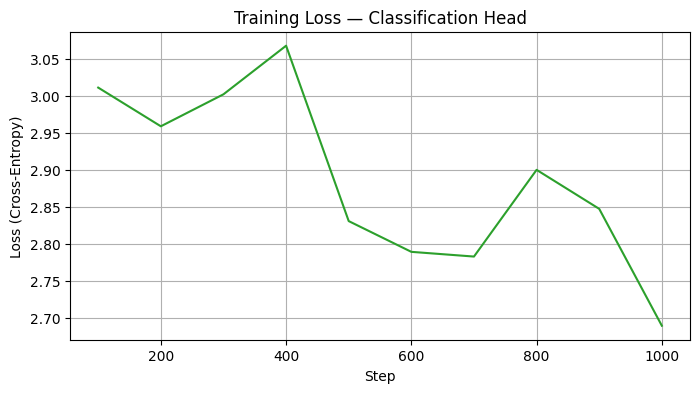

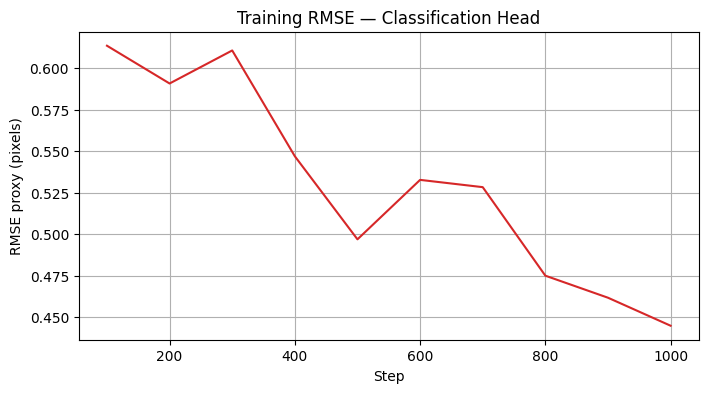

In [39]:


# --- Classification model plots ---
plt.figure(figsize=(8,4))
plt.plot(hist_cls["steps"], hist_cls["loss"], color="tab:green")
plt.xlabel("Step"); plt.ylabel("Loss (Cross-Entropy)")
plt.title("Training Loss — Classification Head")
plt.grid(True)
plt.show()

plt.figure(figsize=(8,4))
plt.plot(hist_cls["steps"], hist_cls["rmse"], color="tab:red")
plt.xlabel("Step"); plt.ylabel("RMSE proxy (pixels)")
plt.title("Training RMSE — Classification Head")
plt.grid(True)
plt.show()


In [71]:

def test_homography_head(head="cls", ckpt_reg="checkpoints/homography_reg_best.pt", ckpt_cls="checkpoints/homography_cls_best.pt"):
    ckpt = ckpt_reg if head == "reg" else ckpt_cls

    s_full = sample_with_full(base_eval, return_cls=True)
    x_np      = s_full["x"]
    y_reg_np  = s_full["y_reg"]
    x0, y0    = map(int, s_full["xy"])
    gray_full = s_full["gray_full"]
    warped_gt = s_full["warped_full"]
    patch_sz  = base_eval.patch

    model = load_model(head, ckpt, bins=BINS, device=device)
    model.eval()

    with torch.no_grad():
        xt = torch.from_numpy(x_np).unsqueeze(0).float().to(device)
        if head == "reg":
            pred = model(xt)
            pred_offsets = pred[0].cpu().numpy()
        else:
            logits = model(xt)
            probs  = torch.softmax(logits, dim=-1)
            centers = torch.linspace(-base_eval.max_jitter, base_eval.max_jitter, BINS, device=device)
            pred_offsets = (probs * centers).sum(dim=-1)[0].cpu().numpy()

    rmse = float(torch.sqrt(F.mse_loss(
        torch.from_numpy(pred_offsets).float(),
        torch.from_numpy(y_reg_np).float()
    )))

    print(f"\n=== Homography Test ({head.upper()} head) ===")
    print("GT offsets (8):   ", np.round(y_reg_np, 3))
    print("Pred offsets (8): ", np.round(pred_offsets, 3))
    print("RMSE (pixels):    ", rmse)

    draw_homography_overlay(
        gray_full, x0, y0, patch_sz,
        offsets_pred=pred_offsets,
        offsets_gt=y_reg_np,
        title=f"Full-image homography — RED=pred, GREEN=GT (head={head})"
    )

    aligned_pred = warp_full_with_pred(gray_full, x0, y0, patch_sz, pred_offsets)
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(gray_full, cmap="gray"); axs[0].set_title("Original full"); axs[0].axis("off")
    axs[1].imshow(warped_gt, cmap="gray"); axs[1].set_title("GT warped full (H^-1)"); axs[1].axis("off")
    axs[2].imshow(aligned_pred, cmap="gray"); axs[2].set_title("Pred warped full (H_pred^-1)"); axs[2].axis("off")
    plt.suptitle(f"Full-image alignment using predicted homography ({head})")
    plt.show()

    return {
        "gt_offsets": y_reg_np,
        "pred_offsets": pred_offsets,
        "rmse": rmse,
        "gray_full": gray_full,
        "aligned_pred": aligned_pred,
        "warped_gt": warped_gt
    }


In [67]:
# result_reg = test_homography_head("reg")



Loaded cls model from: checkpoints/homography_cls_best.pt

=== Homography Test (CLS head) ===
GT offsets (8):    [  1.   4. -14.  14.  11.  12.   6.  -2.]
Pred offsets (8):  [-1.408  8.18  -1.9   10.76  -0.778  0.069 -0.235 -2.013]
RMSE (pixels):     7.906868934631348


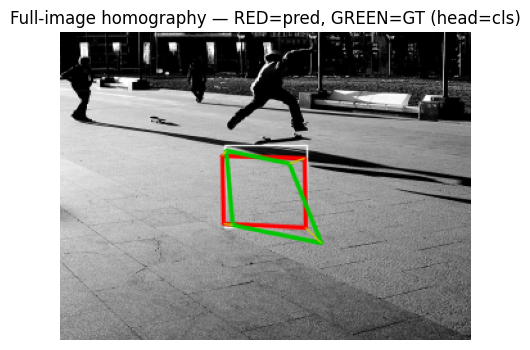

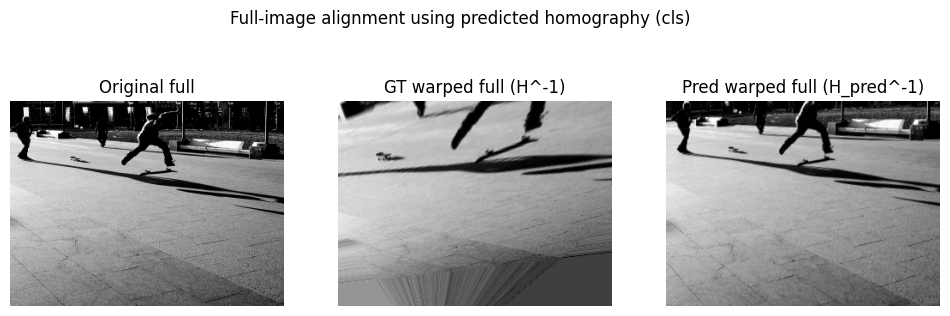

In [87]:
result_cls = test_homography_head("cls")